# Ensembling Shallow Siamese Neural Network Architectures for Printed Documents Verification in Data-Scarcity Scenarios

## 1- Freedom to Print Can be a Problem}
* There is no regulation or established forensic techniques for printed documents:
* Documents of criminal interest can be printed (terrorist plans, corruption proofs, fake currency, counterfeited packages, etc.).
    * Fake Badges can be printed to give access to events for unauthorized people.
    * Pedophiles can print and distribute child porn to avoid the controls over the Internet of security agencies 
    * Counterfeited products can be packaged with materials that resemble the original ones.
    * International Chamber of Commerce has raised an alarm of 3.7 trillion loss due to counterfeiting and piracy, with 5.4 million jobs at risk by 2022.
    * According to the World Health Organization, up to half of the malaria medications could be fake
    
<img src="banconote_false.png" alt="Alt text that describes the graphic" title="Title text" />

## 2- Limitation of Existing Techniques

 *  The best approaches in the literature, in particular, approaches based on Convolutional Neural Networks (CNNs) and Deep Learning (DL) <b> require a huge amount of data </b>.
          
* <b> Printer Inks/Toners are among the most expensive liquids in the world </b>
* <b> It requires though and hardworking procedures to build a big dataset in order to train such models properly </b>
* <b> Existing works in the literature assume that the printer source universe is limited (closed set) </b>

<img src="closed_set_attribution.png" alt="Alt text that describes the graphic" title="Title text" />

## 3- Proposed Methodology

* We propose an Ensemble of Siamese Shallow Networks for Printed Documents Verification}
* We solve the abovementioned issues by proposing     
    * Shallow Novel Networks to work with small data
    * Siamese Networks for one-shot, open set and verification of printed documents (instead of classification)
    * An Ensemble of Networks to maximize the accuracy under training data scarcity

    <img src="proposed_siamese.png" alt="Alt text that describes the graphic" title="Title text" />
    

## 4- Siamese Networks

* Siamese Networks (SNNs) are a special kind of neural networks focused on <b> verification</b>
* A pair of inputs are given to the network with their labels (0-different patterns, 1-same pattern)
* Given a suspect document and a template (with identity already known), the network will point out if the patterns are similar or not
* In our case, we would like to know if <b> two documents come or not from the same printer</b> 

* Siamese Networks have the following advantages over common CNNs: 
    * they learn to find similarities or dissimilarities between different documents according to the printing sources
    * They are well known for their one-shot learning capabilities
    * Since they learn to match - or unmatch - similar pairs no matter their class labels, they can be used in an <b>open set modality</b>
    
    
<img src="snn-how-they-work.png" alt="Alt text that describes the graphic" title="Title text" />

## 5- Preparing Data for Siamese Networks

* The full images are not necessary for the printer verification problem, as <b> some low energized areas could not have information enough to differentiate or equalize pairs of images</b>.

* Given a pair of random documents, we <b> select top-10 high energized 64x64x3 patches from each of them and pair them, so the SNN learns if they are from the same printer (label 1) or different printers (label 0).
    
<img src="pairs_blocks.png" alt="Alt text that describes the graphic" title="Title text" />

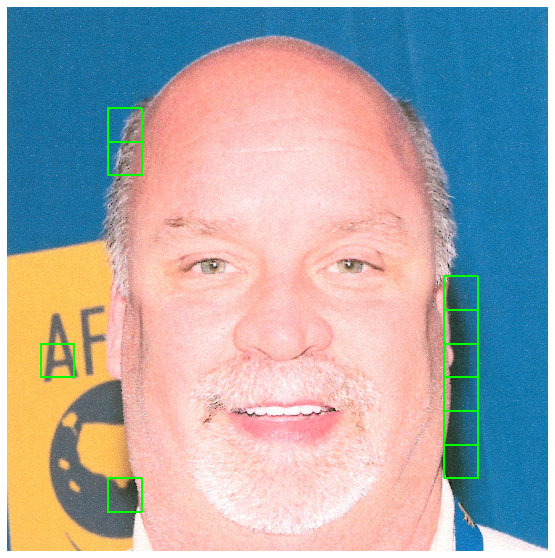

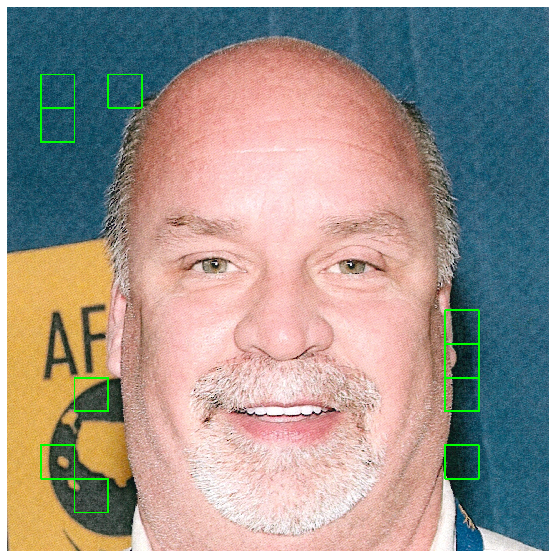

In [9]:
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer

import imutils
#Example, how to find top energized blocks
import cv2
import numpy as np
import sys
import argparse

from skimage import data
from skimage import color
from skimage.util import view_as_blocks
from sklearn.feature_extraction import image

from skimage.morphology import disk
import pywt

import numpy as np
import os
from matplotlib import pyplot as plt

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles  

def show_blocks_variance(printer_name):
    img = cv2.imread("./"+printer_name+"-139.jpg")              #main image
       
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    listOfFiles = getListOfFiles("blocks/128/"+printer_name+"/139")

    # Iterate in the files
    for elem in listOfFiles:
        template = cv2.imread(elem, cv2.IMREAD_GRAYSCALE)      #subimage
        w,h = template.shape[::-1]

        result = cv2.matchTemplate(gray_img,template, cv2.TM_CCOEFF_NORMED)
    
        loc= np.where(result == np.amax(result))

    
        for pt in zip(*loc[::-1]):
            cv2.rectangle(img, pt,(pt[0] + w,pt[1] +h), (0,255,0),5)
    
    fig = plt.figure()
    fig.set_size_inches(15,10)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),interpolation='nearest')
    plt.axis('off')

    plt.show()

show_blocks_variance("Epson-WorkForce-WF-7715")
show_blocks_variance("KyoceraTaskAlfa3551ci")

## 6- Ensembling Heterogeneous Siamese Networks

The architectures of the siamese networks and the work done can be found <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9529175&tag=1">HERE</a>

# 7- Checking one document whose printer is inside the dataset

### Function to get high energized patches from any image

In [10]:
def auto_canny(image, sigma=0.33):
    #Smooth the image using a Gaussian filter to remove high frequency noise.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged
    
def calculate_energy(block):

    canny_filtered=auto_canny(block)
    m,n = canny_filtered.shape
    cA, (cH, cV, cD) = pywt.dwt2(canny_filtered,'db1')
    # a - LL, h - LH, v - HL, d - HH as in matlab
    cHsq = [[elem * elem for elem in inner] for inner in cH]
    cVsq = [[elem * elem for elem in inner] for inner in cV]
    cDsq = [[elem * elem for elem in inner] for inner in cD]
    energy = (np.sum(cHsq) + np.sum(cVsq) + np.sum(cDsq))/(m*n)
    return(energy)

def get_high_energized_patches(img,mCols):
    energies = []
    coordinates= []
    
    block_shape = np.array((mCols, mCols, 3))
    nblocks = np.array(img.shape) // block_shape  # integer division
    crop_r, crop_c, crop_ch = nblocks * block_shape
    cropped_img = img[:crop_r, :crop_c, :crop_ch]
    Blocks = view_as_blocks(cropped_img, block_shape=(mCols, mCols, 3))
    
    Blocks_list=[]
    

    for row in range(Blocks.shape[0]):
        for column in range(Blocks.shape[1]):
            
            block=np.squeeze(Blocks[row,column], axis=0)                
            energy=calculate_energy(block)
            energies.append(energy)
            coordinates.append(np.array([row,column]))

        
    #Now, we will sort the energies, and save only blocks that have the top 10 energies
    energies = np.array(energies)
    coordinates= np.array(coordinates)
    #Indices of the top 50 elements of the energies (You can increase if you want, but at a cost of bigger dataset)
    #If there are no elements enough, use what it has
    if (energies.shape[0]>=10):
        indices_sorted =energies.argsort()[-10:][::-1]
        
    else:   
        indices_sorted =energies.argsort()[-np.count_nonzero(energies):][::-1]
    
    for i in range(0,indices_sorted.shape[0]):
       
        
        #I will save this image. I need to reconstruct it
        r=coordinates[indices_sorted[i],0]
        c=coordinates[indices_sorted[i],1]
        
        window_test=np.squeeze(Blocks[r,c], axis=0) 
        Blocks_list.append(window_test)
    
    Blocks_list=np.array(Blocks_list)
    
    return Blocks_list
        
        

In [11]:
def make_prediction(image_patches_1, image_patches_2, model, threshold):

    #Predicao para cada par
    predictions_for_that_pair=[]
   
    
    #Vamos comecar a predicao bloco correspondente a bloco correspondente
    for i in range(0,image_patches_1.shape[0]):
        
        #Vamos ler os pares, preparar para o teste e testar
        #Lendo par (imagem1)
        pair_1=image_patches_1[i]
        #Preparando par (imagem1)
        pair_1 = np.expand_dims(pair_1, axis=-1)
        pair_1 = np.expand_dims(pair_1, axis=0)
        pair_1 = pair_1 / 255.0

        #Lendo par (imagem2)
        pair_2=image_patches_2[i]
        #Preparando par (imagem1)
        pair_2 = np.expand_dims(pair_2, axis=-1)
        pair_2 = np.expand_dims(pair_2, axis=0)
        pair_2 = pair_2 / 255.0

        #Testando o par
        predictions_for_those_blocks = model.predict([pair_1, pair_2])
        
        #The sigmoid activation function is used here because the output range of the function is [0, 1]. 
        #An output closer to 0 implies that the image pairs are less similar (and therefore from different classes), 
        #while a value closer to 1 implies they are more similar (and more likely to be from the same class).		
               
        if (predictions_for_those_blocks[0][0]<threshold):
            prediction=1
        else:
            prediction=0

    predictions_for_that_pair.append(prediction)
    predictions_for_that_pair=np.array(predictions_for_that_pair)
    #vejamos a moda
    vals,counts = np.unique(predictions_for_that_pair, return_counts=True)
    index = np.argmax(counts)
    mode=vals[index]
    
    return mode

def final_decision(v1,v2,v3):
    
    predictions_for_that_pair=np.array((v1,v2,v3))
    vals,counts = np.unique(predictions_for_that_pair, return_counts=True)
    index = np.argmax(counts)
    mode=vals[index]
    
    if mode==0:
        return_text="Different Printer"
    else:
        return_text="Same Printer"
    
    return return_text

    

### Now Let us Load Models First

In [13]:
from tensorflow.keras.models import load_model

print("\n STEP 1: Loading models \n")
MCS_classifier=load_model("models/ADHOC3/RMSPROP/siamese_model/", compile=False)
MCI_classifier=load_model("models/BDHOC3/adam/siamese_model/", compile=False)
SX_classifier=load_model("models/CDHOC4/rmsprop/siamese_model/", compile=False)


 STEP 1: Loading models 



### Function to show images

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].axis('off')
        list_axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),interpolation='nearest')
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    
    _ = plt.show()

### Now Let us Test Randomly two images


 TASK: I will check if two images come from the same printer or not. 


 I will select two random images and then tell you the decision 

Image 0 was printed by CANON-C600-1
Image 1 was printed by CANON-C600-2


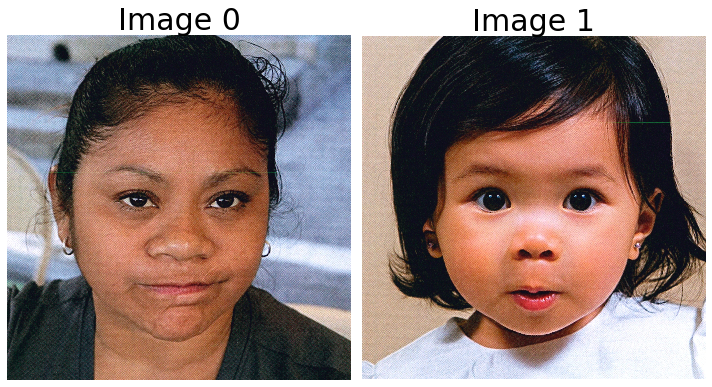

2022-04-29 12:25:16.175588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-29 12:25:16.249172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Same Printer


In [15]:
from pyimagesearch import utils
import siamese_test_utils as stu
from scipy import stats
import os
import random
import cv2

print("\n TASK: I will check if two images come from the same printer or not. \n")
print("\n I will select two random images and then tell you the decision \n")

directory_printed_images=os.listdir("templates/")
random_choice=random.sample(directory_printed_images, k=2)

printer_image_test_1= random_choice[0].replace(".jpg", "")
printer_image_test_2= random_choice[1].replace(".jpg", "")

print("Image 0 was printed by " +printer_image_test_1)
print("Image 1 was printed by " +printer_image_test_2)


image1=cv2.imread("templates/"+random_choice[0])
image_template_patches=get_high_energized_patches(image1,64)
image_template_patches=np.asarray(image_template_patches)

image2=cv2.imread("templates/"+random_choice[1])
image_test_patches=get_high_energized_patches(image2,64)
image_test_patches=np.asarray(image_test_patches)

list_images = [image1, image2]
show_image_list(list_images, figsize=(10, 10),  grid=False)


result1=make_prediction(image_test_patches,image_template_patches,MCS_classifier,0.5)
result2=make_prediction(image_test_patches,image_template_patches,MCI_classifier,0.5)
result3=make_prediction(image_test_patches,image_template_patches,SX_classifier,0.5)
return_text=final_decision(result1,result2, result3)
print(return_text)

# Now it is a fixed test, showing some correct and wrong specific classifications


 TASK: I will check if two images come from the same printer or not. 


 I will select two random images and then tell you the decision 

Image 0 was printed by KYOCERA-COLORLASER1
Image 1 was printed by KYOCERA-ECOSYS-2


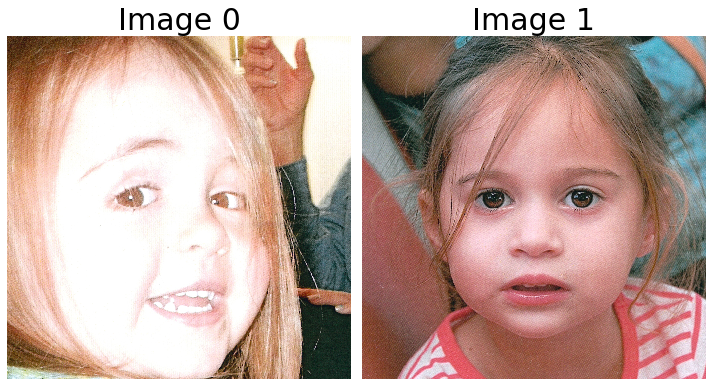

Different Printer


In [18]:
from pyimagesearch import utils
import siamese_test_utils as stu
from scipy import stats
import os
import random
import cv2

print("\n TASK: I will check if two images come from the same printer or not. \n")
print("\n I will select two random images and then tell you the decision \n")

#uncomment and change names here
#fixed_choice=["KYOCERA-ECOSYS-2.jpg","KYOCERA-ECOSYS-1.jpg"] #One mistake example
#fixed_choice=["KYOCERA-COLORLASER2.jpg","KYOCERA-COLORLASER1.jpg"] #One correct classification
#fixed_choice=["KYOCERA-COLORLASER2.jpg","KYOCERA-ECOSYS-1.jpg"] #one mistake example
fixed_choice=["KYOCERA-COLORLASER1.jpg","KYOCERA-ECOSYS-2.jpg"] #One correct classification

printer_image_test_1= fixed_choice[0].replace(".jpg", "")
printer_image_test_2= fixed_choice[1].replace(".jpg", "")

print("Image 0 was printed by " +printer_image_test_1)
print("Image 1 was printed by " +printer_image_test_2)


image1=cv2.imread("templates/"+fixed_choice[0])
image_template_patches=get_high_energized_patches(image1,64)
image_template_patches=np.asarray(image_template_patches)

image2=cv2.imread("templates/"+fixed_choice[1])
image_test_patches=get_high_energized_patches(image2,64)
image_test_patches=np.asarray(image_test_patches)

list_images = [image1, image2]
show_image_list(list_images, figsize=(10, 10),  grid=False)

result1=make_prediction(image_test_patches,image_template_patches,MCS_classifier,0.5)
result2=make_prediction(image_test_patches,image_template_patches,MCI_classifier,0.5)
result3=make_prediction(image_test_patches,image_template_patches,SX_classifier,0.5)
return_text=final_decision(result1,result2, result3)
print(return_text)